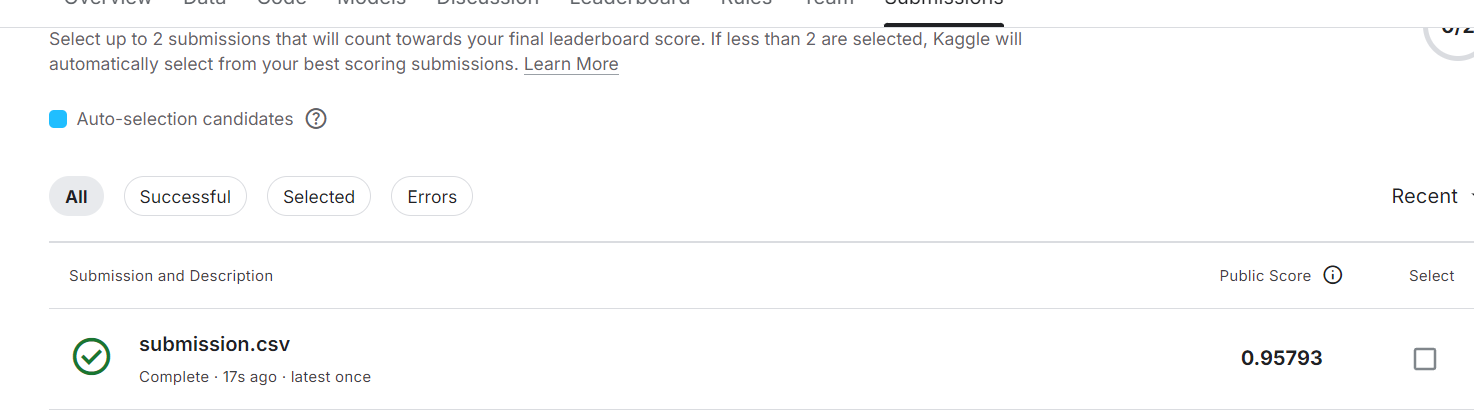

IF YOU LIKE THE NOTEBOOK , PLEASE DO UPVOTE IT :))))!!

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [129]:
loan_train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')

In [130]:
loan_train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [131]:
loan_train

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10,0
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8,1
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2,1
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3,0


In [132]:
print("Rows: ", len(loan_train))
print("Columns: ", len(loan_train.columns))
print("Shape : ", loan_train.shape)
loan_train.columns

Rows:  58645
Columns:  13
Shape :  (58645, 13)


Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')

In [133]:
loan_train.describe(exclude=[np.number])

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,58645,58645,58645,58645
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,30594,12271,20984,49943


In [134]:
loan_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,58645.0,29322.000000,16929.497605,0.00,14661.00,29322.00,43983.00,58644.00
person_age,58645.0,27.550857,6.033216,20.00,23.00,26.00,30.00,123.00
person_income,58645.0,64046.172871,37931.106978,4200.00,42000.00,58000.00,75600.00,1900000.00
person_emp_length,58645.0,4.701015,3.959784,0.00,2.00,4.00,7.00,123.00
loan_amnt,58645.0,9217.556518,5563.807384,500.00,5000.00,8000.00,12000.00,35000.00
loan_int_rate,58645.0,10.677874,3.034697,5.42,7.88,10.75,12.99,23.22
loan_percent_income,58645.0,0.159238,0.091692,0.00,0.09,0.14,0.21,0.83
cb_person_cred_hist_length,58645.0,5.813556,4.029196,2.00,3.00,4.00,8.00,30.00
loan_status,58645.0,0.142382,0.349445,0.00,0.00,0.00,0.00,1.00


In [135]:
loan_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [136]:
loan_train.isnull().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [137]:
loan_train['loan_status'].value_counts()


loan_status
0    50295
1     8350
Name: count, dtype: int64

<Axes: >

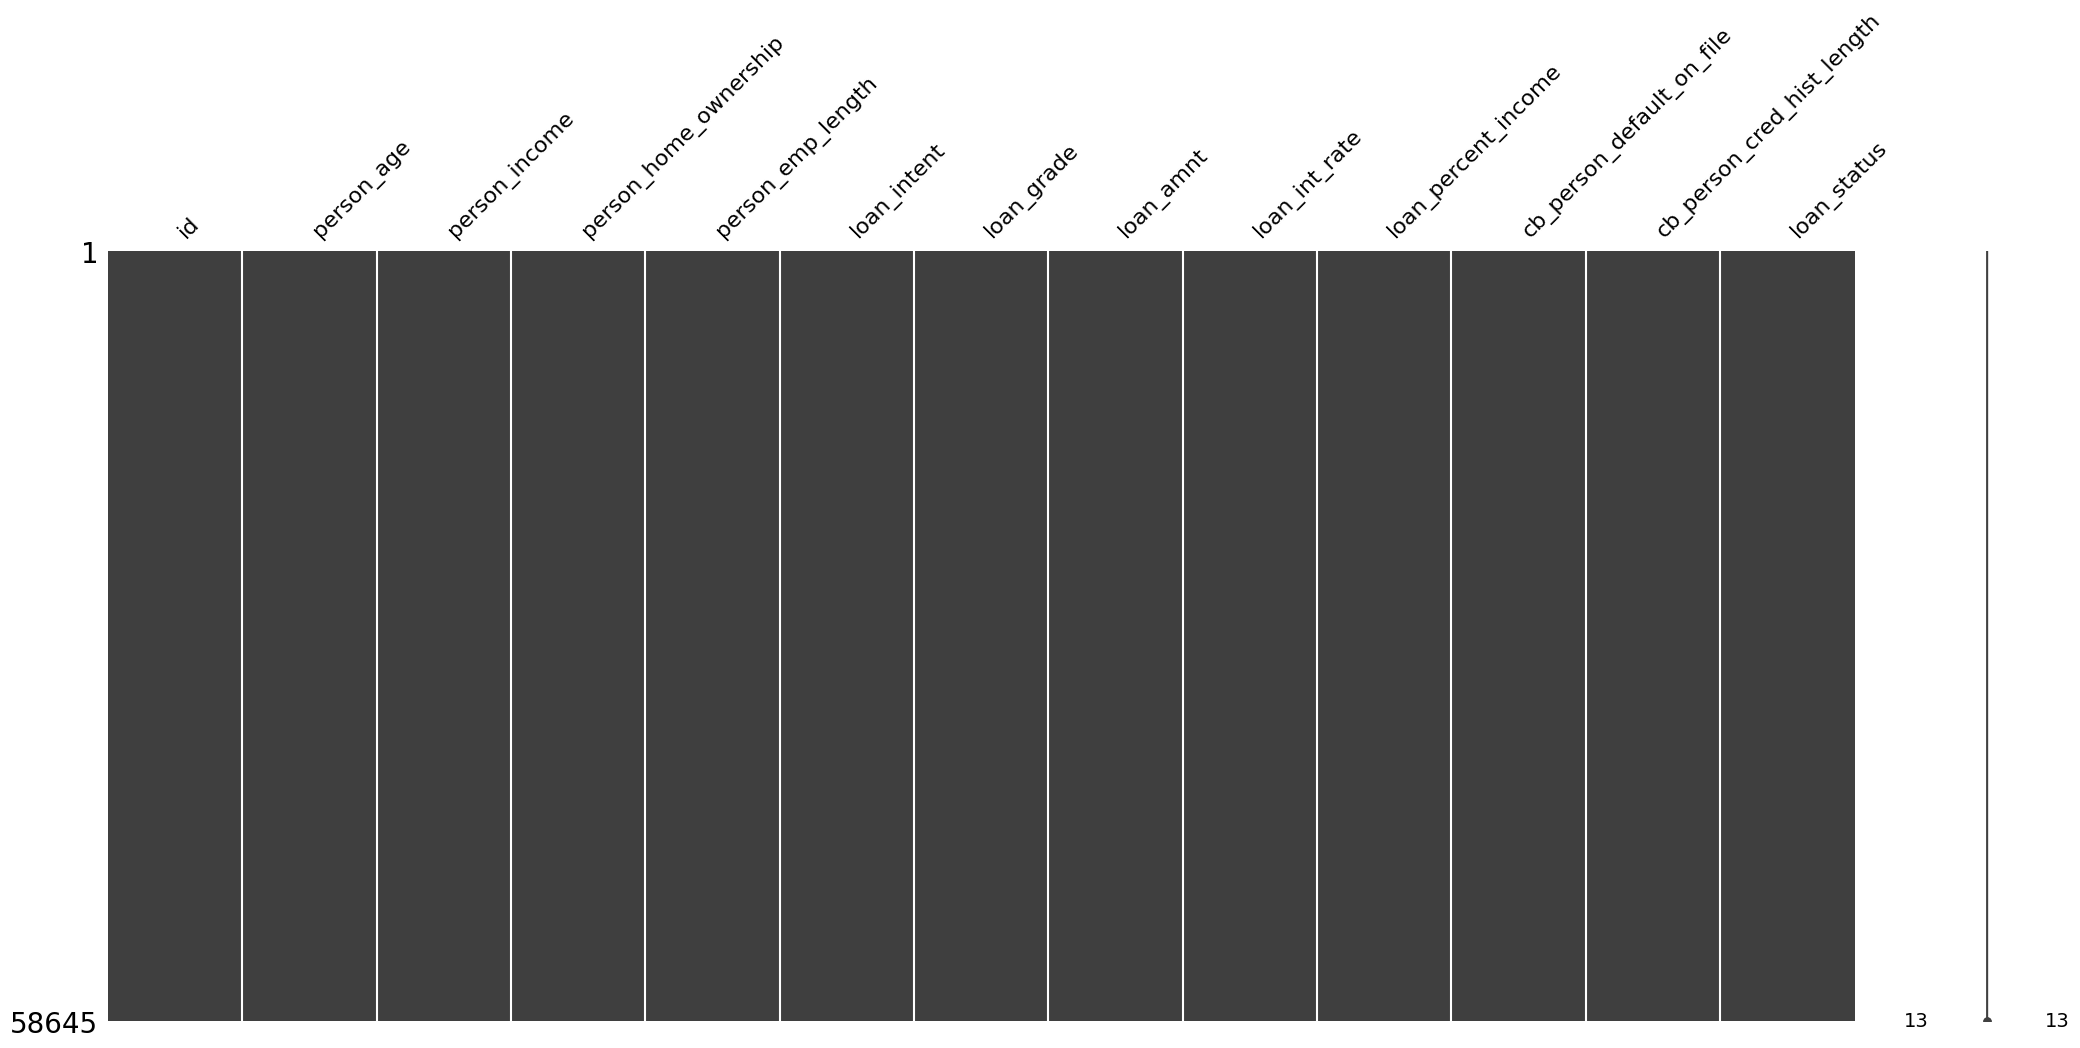

In [138]:
msno.matrix(loan_train )

In [139]:
loan_train['loan_status'].value_counts(normalize=True).sort_index()

loan_status
0    0.857618
1    0.142382
Name: proportion, dtype: float64

In [140]:
loan_train

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10,0
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8,1
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2,1
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3,0


In [141]:
loan_test

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
39093,97738,22,31200,MORTGAGE,2.0,DEBTCONSOLIDATION,B,3000,10.37,0.10,N,4
39094,97739,22,48000,MORTGAGE,6.0,EDUCATION,A,7000,6.03,0.15,N,3
39095,97740,51,60000,MORTGAGE,0.0,PERSONAL,A,15000,7.51,0.25,N,25
39096,97741,22,36000,MORTGAGE,4.0,PERSONAL,D,14000,15.62,0.39,Y,4


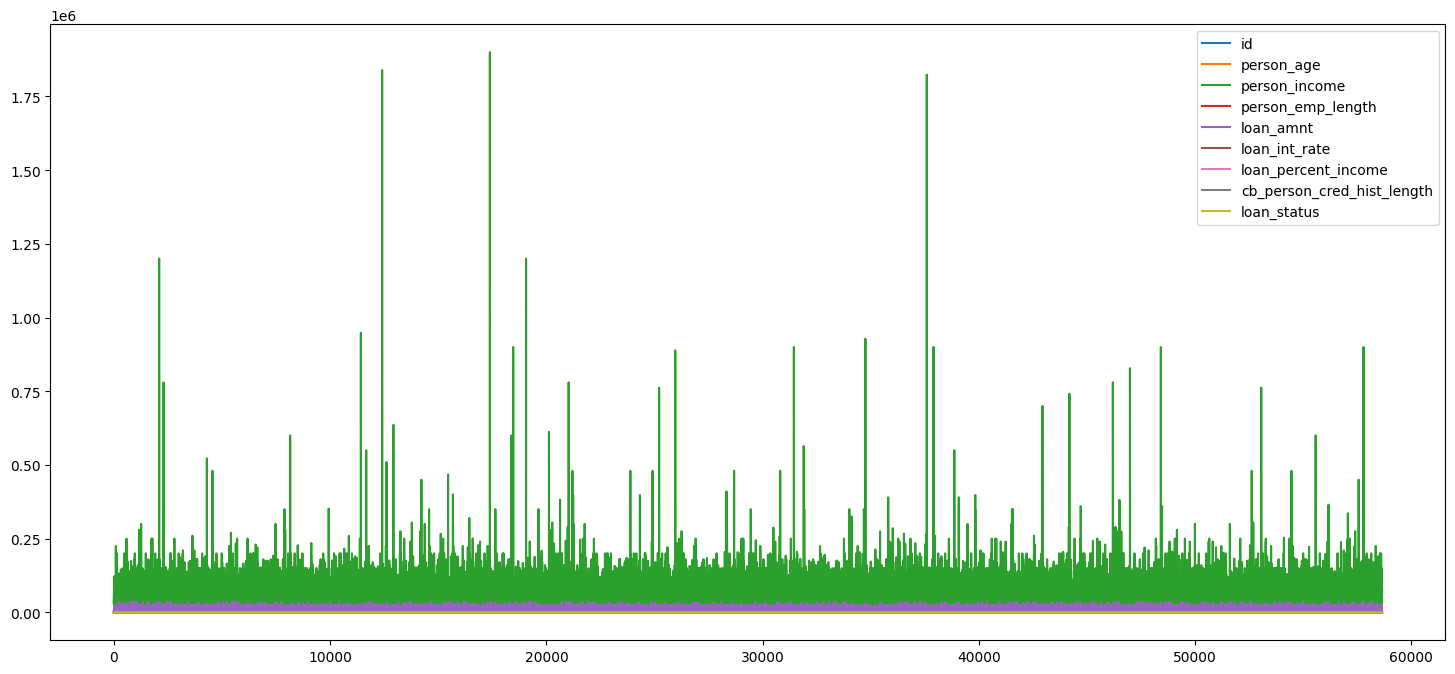

In [142]:
loan_train.plot(figsize=(18, 8))

plt.show()

In [143]:
print(loan_train.dtypes)


id                              int64
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object


In [144]:
loan_train_numeric = loan_train.select_dtypes(include=[np.number])


One hot encoding

In [145]:
loan_train_encoded = pd.get_dummies(loan_train, drop_first=True)


In [146]:
correlation_matrix = loan_train_numeric.corr()
# or if you used one-hot encoding
# correlation_matrix = loan_train_encoded.corr()


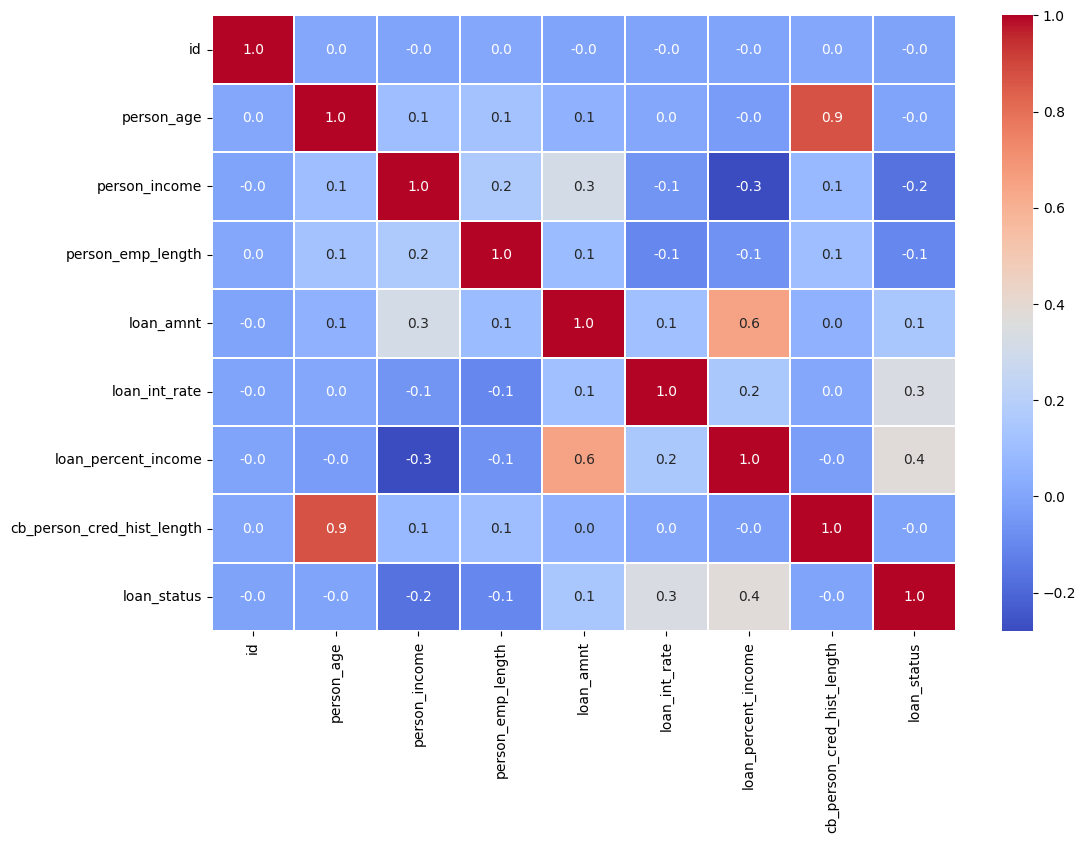

In [147]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt='.1f', linewidths=.1)
plt.show()


In [148]:
X = loan_train.drop(columns = ['loan_status'])
y = loan_train['loan_status'].values

In [149]:
categorical_columns = loan_train.select_dtypes(exclude=['number']).columns.tolist()
print(categorical_columns)

['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


**XGBoostModel**

In [150]:
from typing import Dict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier

In [151]:
def return_estimator(params:Dict = {}):
    return Pipeline([
        (
            'preproc', 
            ColumnTransformer(
                transformers = [('ohe', OneHotEncoder(sparse_output=False), categorical_columns)],
                remainder='passthrough',
                sparse_threshold=0
            ).set_output(transform='pandas')
        ),
        ('xgb', XGBClassifier(tree_method='hist', **params))
    ])

In [152]:
!pip install botorch optuna-integration

In [153]:
import optuna
print(optuna.__version__)


4.0.0


In [154]:
from typing import Dict, Union
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import optuna
import joblib
import warnings
from optuna.samplers import TPESampler

In [155]:
def fit_and_test_model(
    X: pd.DataFrame, y: np.ndarray,
    train_index: np.ndarray, valid_index: np.ndarray,
    params: Dict[str, Union[str, int, float]] = {}
) -> float:
    
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    model = return_estimator(params)
    
    _ = model.fit(X_train, y_train)
    y_valid_pred = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, y_valid_pred)

def optuna_objective(trial: optuna.trial.Trial) -> float:
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1500, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.75, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 12, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 100, log=True),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 1000, log=True)
    }

    cv_auc = [
        fit_and_test_model(X, y, train_index, valid_index, params) \
            for train_index, valid_index in StratifiedKFold(
                n_splits=5, shuffle=True, random_state=0
            ).split(X, y)
    ]
    return np.mean(cv_auc)


with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=optuna.exceptions.ExperimentalWarning)
    warnings.simplefilter(action="ignore", category=FutureWarning)

    study = optuna.create_study(
        direction='maximize', 
        study_name='xgboost',
        sampler=TPESampler(n_startup_trials=10, seed=2)
    )

    # run optuna for a maximum of 120 trials or 1 hr wall clock
    study.optimize(optuna_objective, timeout=3600, n_trials=120)
    
    
# save the runs
_ = joblib.dump(study, 'xgboost_auc.pkl')

[I 2024-10-02 06:01:57,824] A new study created in memory with name: xgboost
[I 2024-10-02 06:02:01,647] Trial 0 finished with value: 0.9122096278662477 and parameters: {'n_estimators': 219, 'learning_rate': 0.0011872426915762793, 'max_depth': 3, 'subsample': 0.7176611963091384, 'colsample_bytree': 0.4783310218787401, 'reg_alpha': 9.397522821096242e-06, 'reg_lambda': 6.94764639026943e-07, 'gamma': 0.01558510252222362, 'min_child_weight': 7.924356787008142}. Best is trial 0 with value: 0.9122096278662477.
[I 2024-10-02 06:02:05,679] Trial 1 finished with value: 0.934408230958304 and parameters: {'n_estimators': 123, 'learning_rate': 0.06106576779720579, 'max_depth': 3, 'subsample': 0.5672899726724667, 'colsample_bytree': 0.5622203091391718, 'reg_alpha': 4.570448196536859e-07, 'reg_lambda': 0.11695433673868773, 'gamma': 3.4653964518555913, 'min_child_weight': 30.388587370815138}. Best is trial 1 with value: 0.934408230958304.
[I 2024-10-02 06:02:19,018] Trial 2 finished with value: 0.918

In [156]:
fig = optuna.visualization.plot_optimization_history(study, target_name='CV AUC')

fig.update_layout(
    autosize=True,
    width=800,
    height=600
)
fig.show()

In [157]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(
    autosize=True,
    width=800,
    height=400
)
fig.show()

Best hyperparameters

In [158]:
study.best_params

{'n_estimators': 869,
 'learning_rate': 0.028961832288603592,
 'max_depth': 12,
 'subsample': 0.9905823947357582,
 'colsample_bytree': 0.30366733395755025,
 'reg_alpha': 0.0009420605872385055,
 'reg_lambda': 0.2627080428692283,
 'gamma': 1.2701879751831835,
 'min_child_weight': 1.4891648319008788}

Finalised model

In [159]:
model = return_estimator(study.best_params)
_ = model.fit(X, y)

# save model
_ = joblib.dump(model, 'xgboost_loan_approval.pkl')

In [160]:
SUBMISSION TIME AND PREDICITIONS !!!, YAY , YIPEEE!!

SyntaxError: invalid syntax (959993203.py, line 1)

In [161]:
# Load test dataset if it's in a CSV file
test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')


In [167]:
# Assuming `test` has an 'id' column that contains the actual IDs
# Generate predictions (probabilities) for the loan status
loan_status_predictions = model.predict_proba(test)[:, 1]  # Get probabilities for the positive class

# Create the submission DataFrame using the actual 'id' column
submission = pd.DataFrame({
    'id': test['id'],  # Replace with the actual 'id' column from your test dataset
    'loan_status': loan_status_predictions
})

# Save the submission file
submission.to_csv('submission.csv', index=False)

# Check the submission output
submission.head(5)


,id,loan_status
0,58645,0.994955
1,58646,0.016345
2,58647,0.702839
3,58648,0.009580
4,58649,0.062547


In [165]:
# check submission output
submission.head(5)

,id,loan_status
0,58645,0.994955
1,58646,0.016345
2,58647,0.702839
3,58648,0.009580
4,58649,0.062547


In [166]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Full path of the submission file
submission_file_path = os.path.join(current_directory, 'submission.csv')

print("Submission file path:", submission_file_path)


Submission file path: /kaggle/working/submission.csv


IF YOU LIKE THE NOTEBOOK , PLEASE DO UPVOTE IT :))))!!

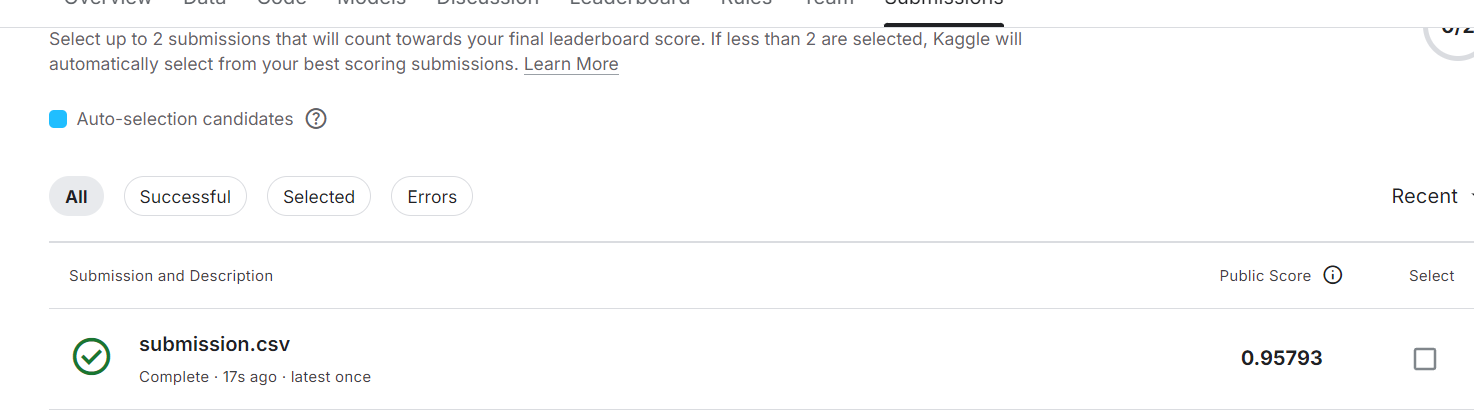
